In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("THELPSD_dataset_test.csv", delimiter = ',')

In [3]:
df.head()
df.columns

Index(['e1', 'e2', 'g12', 'f_nu12', 'f_nu23', 'f_cte1', 'f_cte2', 'ar',
       'fiber_massfrac', 'fiber_density', 'matrix_modulus', 'matrix_poisson',
       'matrix_density', 'm_cte', 'a11', 'a22', 'a12', 'a13', 'a23', 'E1',
       'E2', 'E3', 'G12', 'G13', 'G23', 'nu12', 'nu13', 'nu23', 'CTE11',
       'CTE22', 'CTE33', 'CTE12', 'CTE13', 'CTE23'],
      dtype='object')

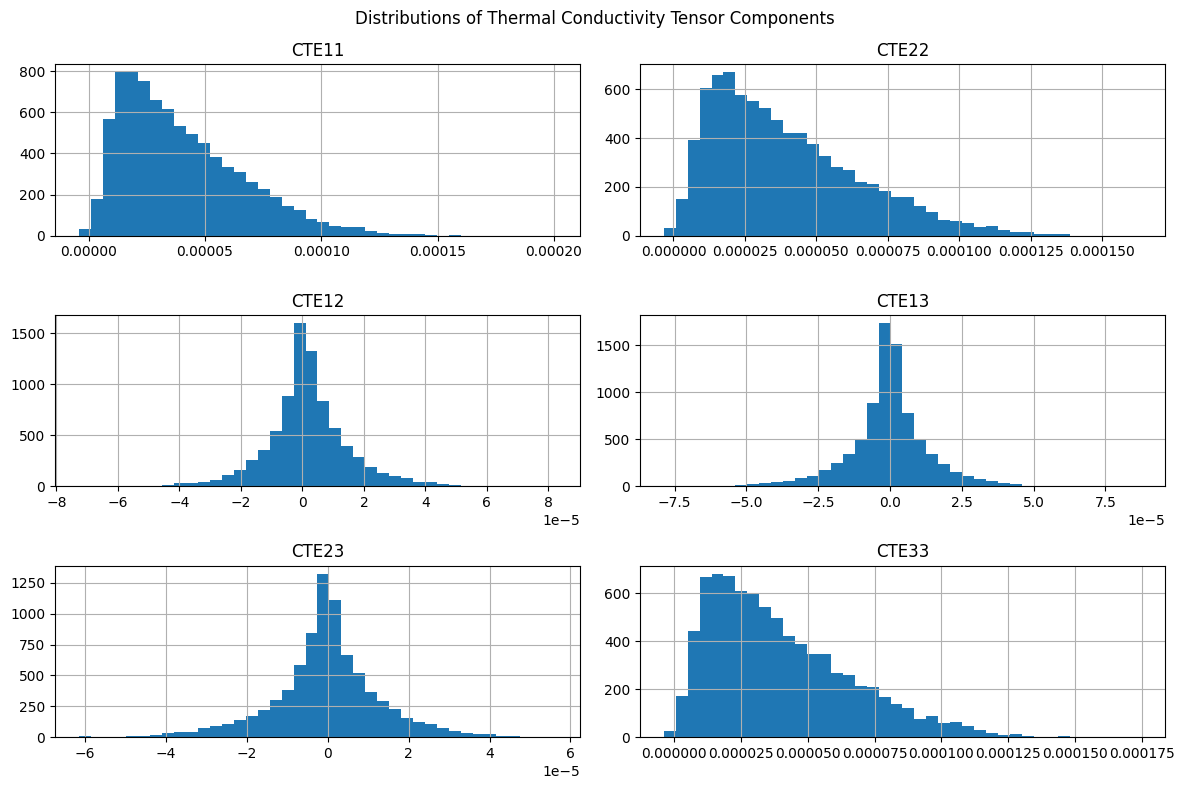

In [5]:
outputs = ['CTE11','CTE22','CTE12','CTE13','CTE23','CTE33']

df[outputs].hist(bins=40, figsize=(12,8))
plt.suptitle("Distributions of Thermal Conductivity Tensor Components")
plt.tight_layout()
plt.show()


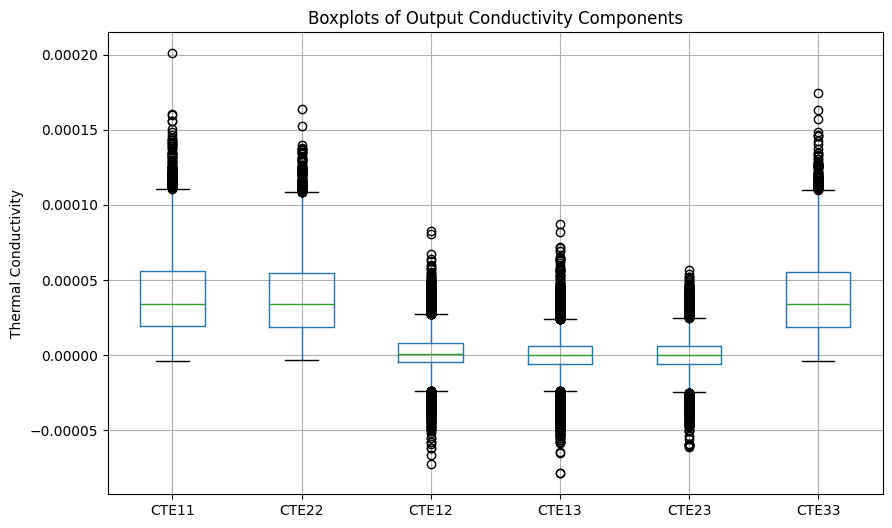

In [6]:
plt.figure(figsize=(10,6))
df[outputs].boxplot()
plt.title("Boxplots of Output Conductivity Components")
plt.ylabel("Thermal Conductivity")
plt.show()


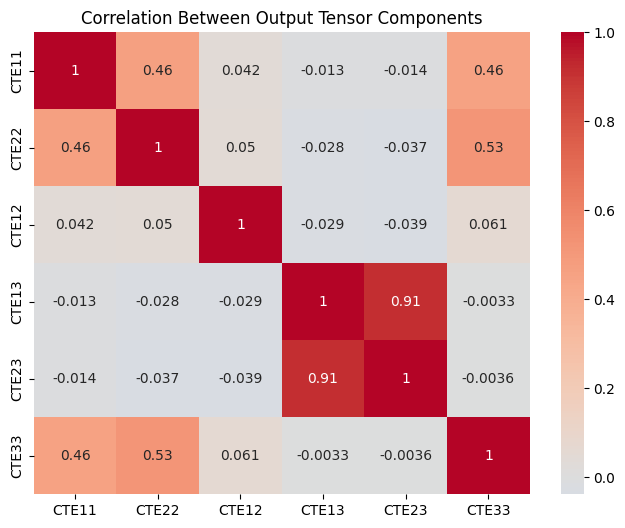

In [7]:
plt.figure(figsize=(8,6))
sns.heatmap(df[outputs].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Between Output Tensor Components")
plt.show()

# check if all of the tensors are positive definite

In [9]:
import numpy as np

def is_spd(row):
    K = np.array([[row.CTE11, row.CTE12, row.CTE13],
                  [row.CTE12, row.CTE22, row.CTE23],
                  [row.CTE13, row.CTE23, row.CTE33]])
    return np.all(np.linalg.eigvals(K) > 0)

df['SPD'] = df.apply(is_spd, axis=1)
print("Fraction of physically valid tensors:", df['SPD'].mean())

Fraction of physically valid tensors: 0.9017333984375


### The above is good, it means that we have sampled a small portion of the negative CTE

In [11]:
def is_spd(row):
    K = np.array([[row.a11, row.a12, row.a13],
                  [row.a12, row.a22, row.a23],
                  [row.a13, row.a23, 1 - row.a11 - row.a22]])
    return np.all(np.linalg.eigvals(K) > 0)

df['SPD'] = df.apply(is_spd, axis=1)
print("Fraction of physically valid tensors:", df['SPD'].mean())

Fraction of physically valid tensors: 1.0


### Lets look at the inputs now

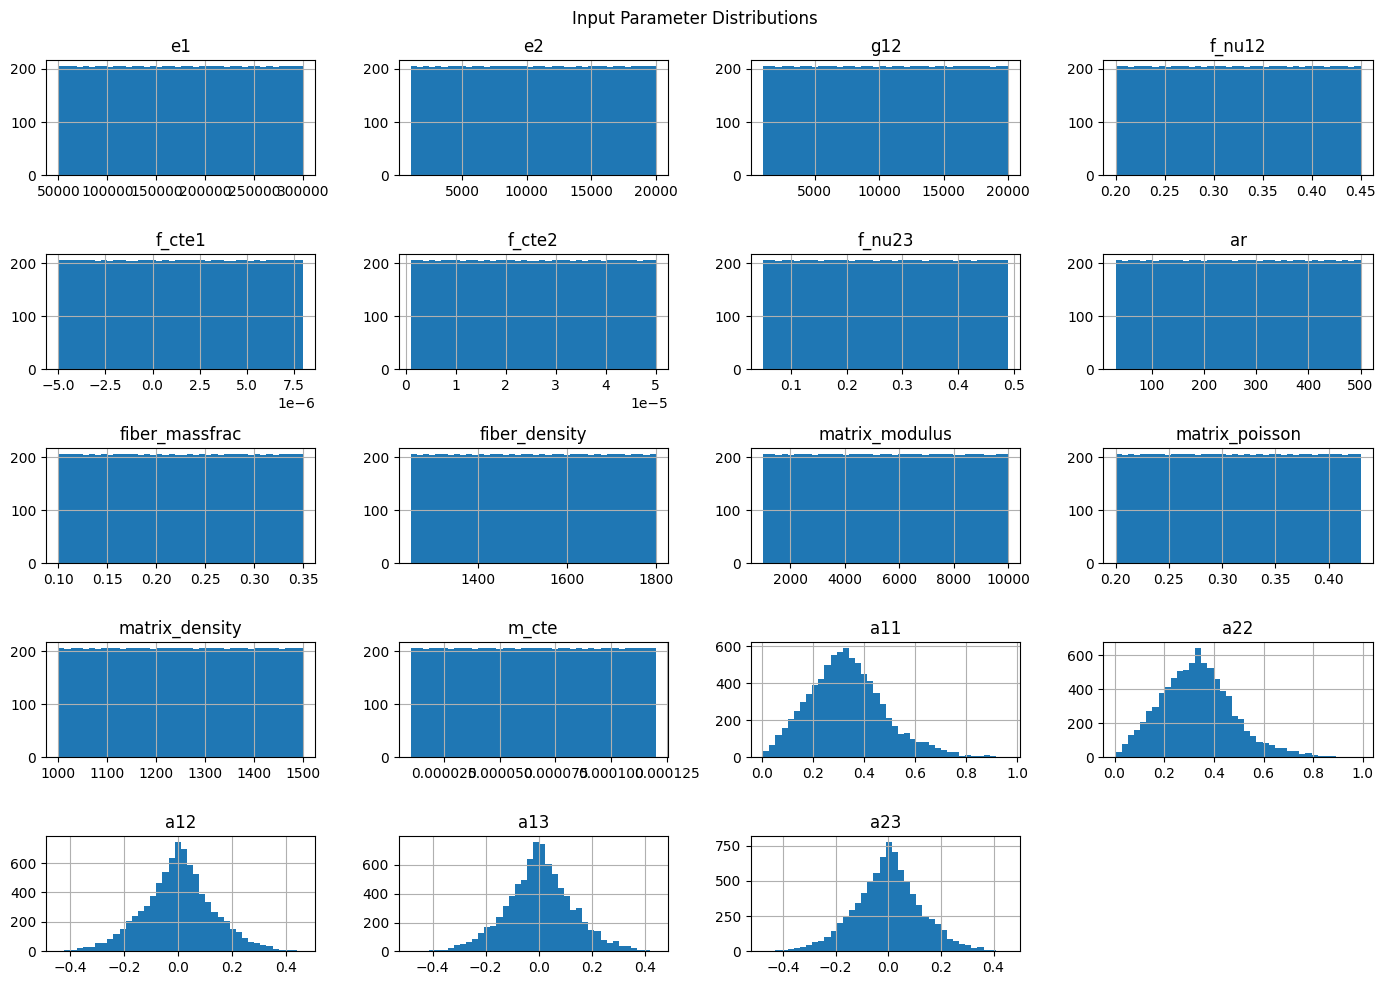

In [13]:
import matplotlib.pyplot as plt

inputs = [
    "e1", "e2", "g12", "f_nu12", "f_cte1",	"f_cte2",
    "f_nu23", "ar", "fiber_massfrac", "fiber_density", "matrix_modulus",
    "matrix_poisson", "matrix_density", "m_cte",
    "a11", "a22", "a12", "a13", "a23", # a33 = 1 - a11 - a22
]

df[inputs].hist(bins=40, figsize=(14,10))
plt.suptitle("Input Parameter Distributions")
plt.tight_layout()
plt.show()

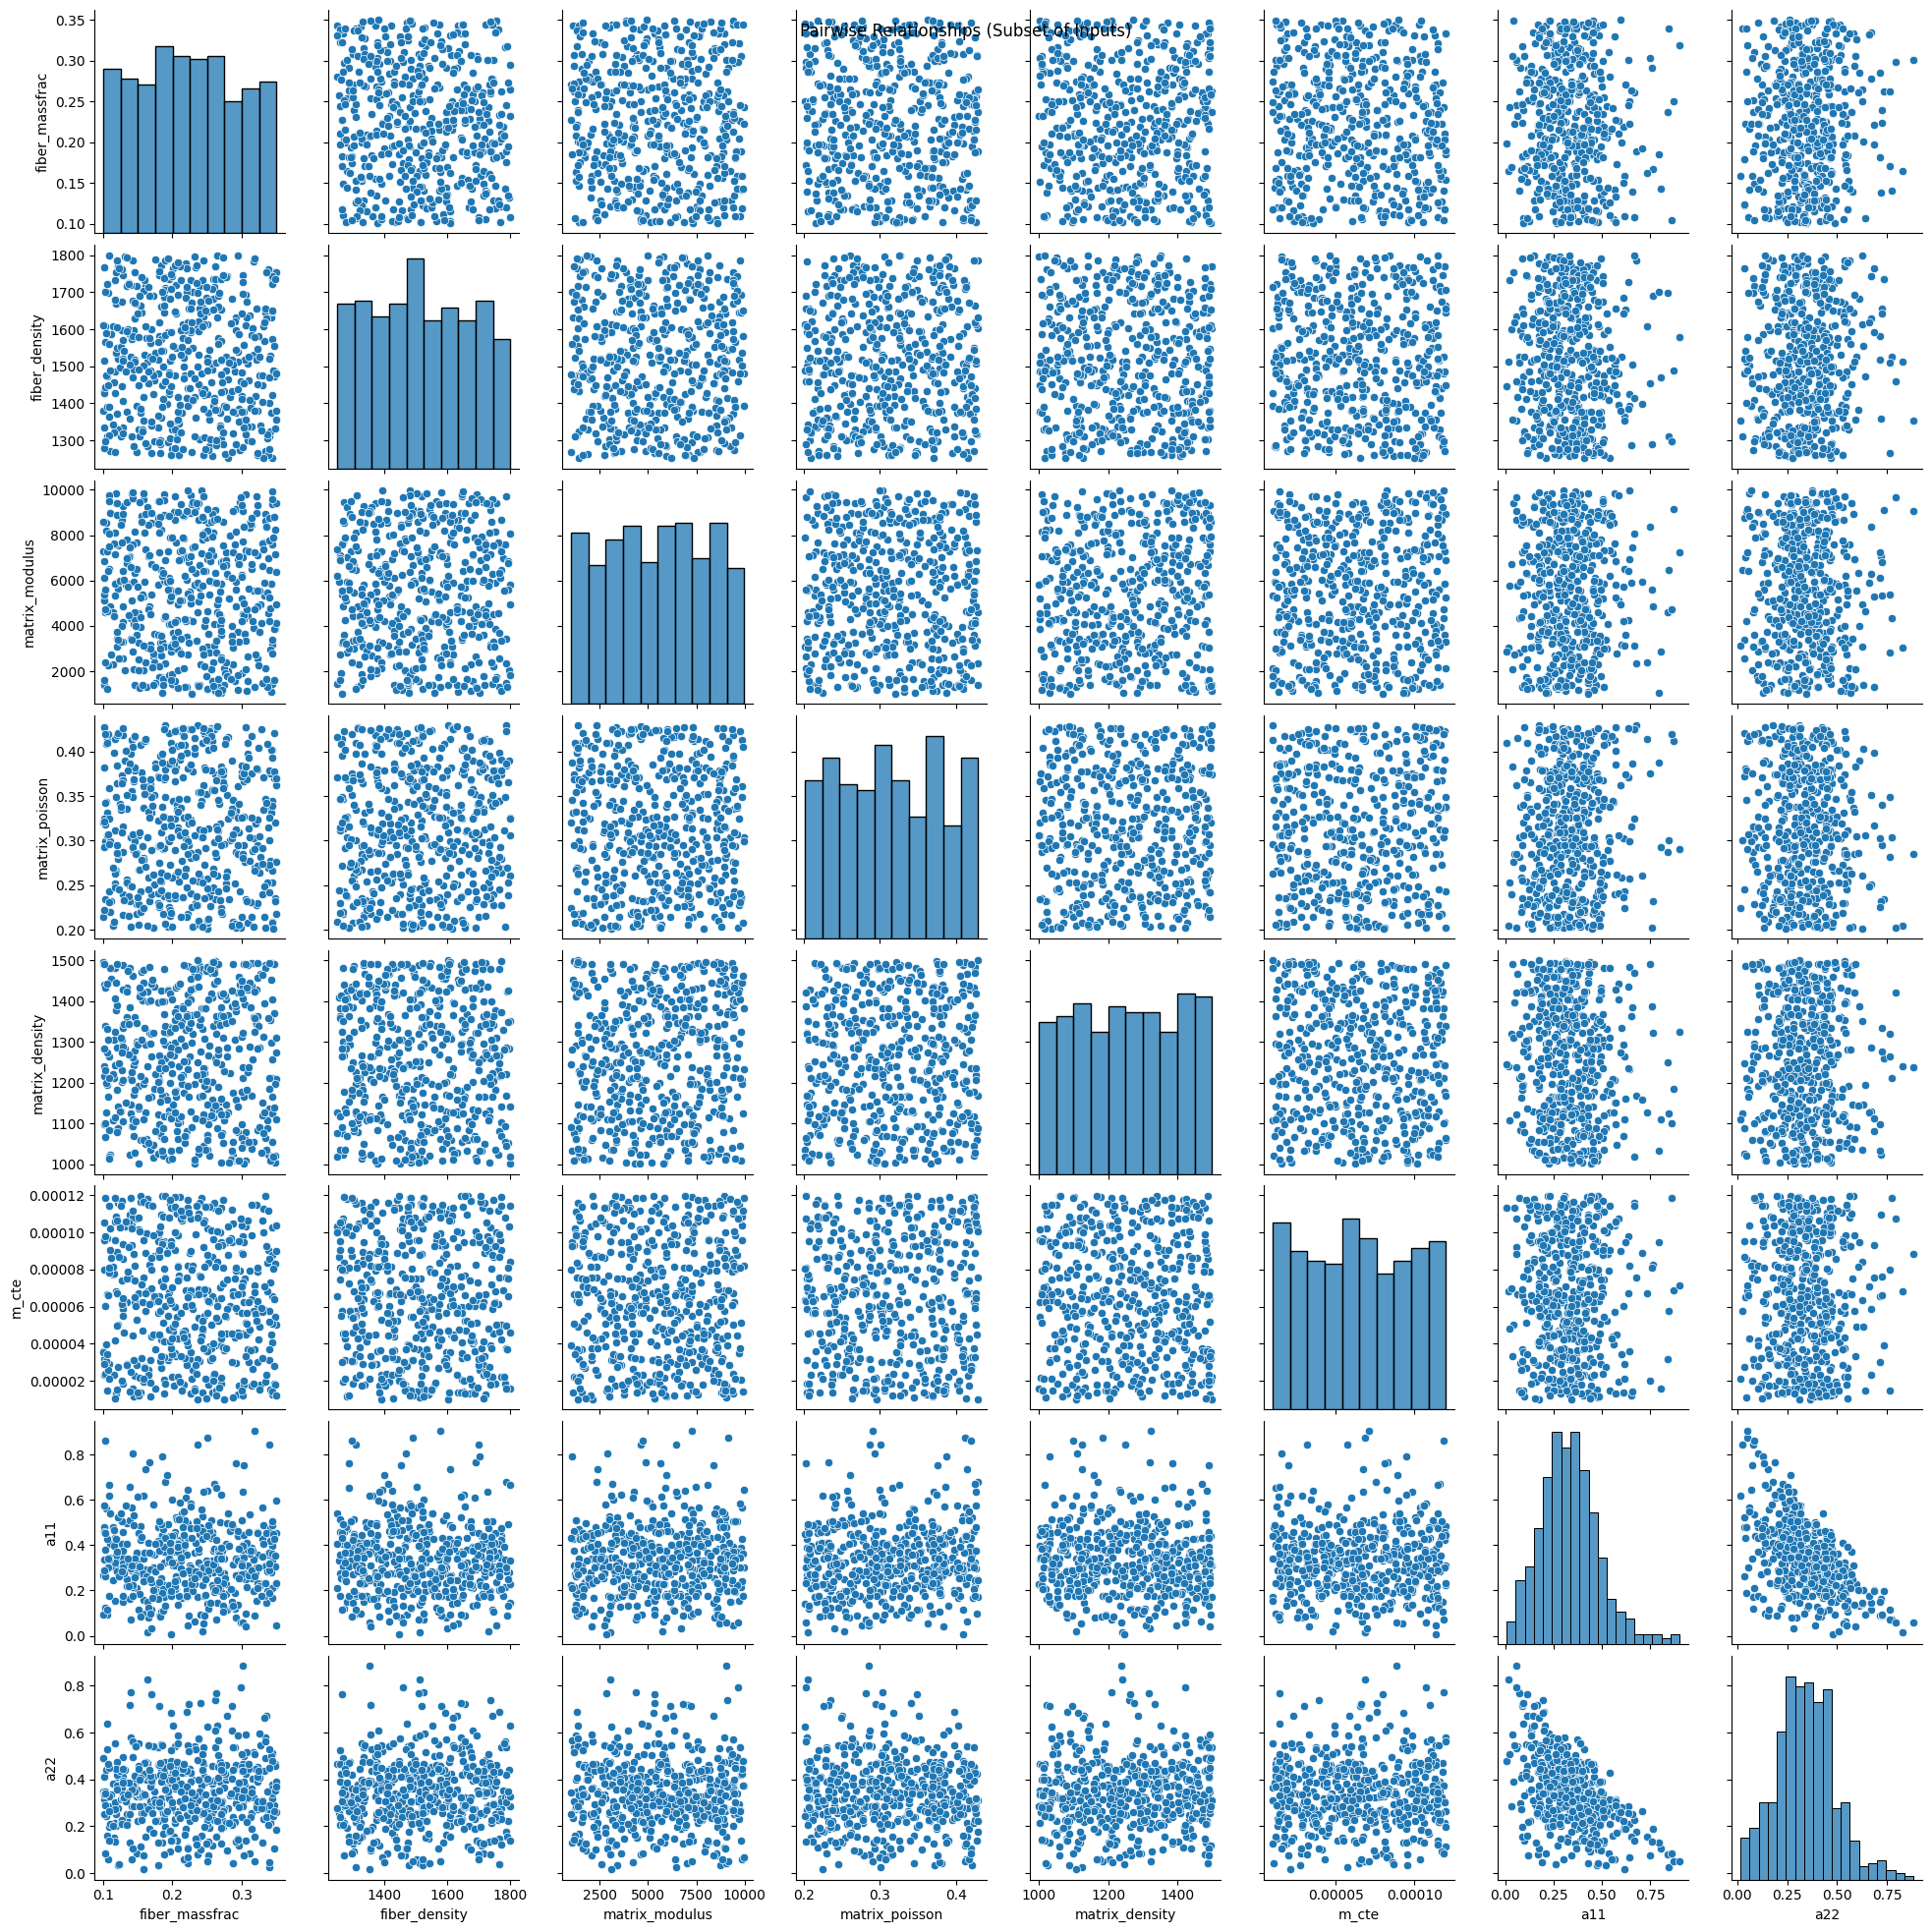

In [15]:

sample_df = df.sample(min(500, len(df)))  # avoid heavy plotting
sns.pairplot(sample_df[inputs[8:16]])  # first 6 to keep readable
plt.suptitle("Pairwise Relationships (Subset of Inputs)")
plt.show()

In [11]:
print("Aspect ratio min:", df['ar_f'].min())

Aspect ratio min: 1.0094211913774778


In [12]:
df['a33'] = 1 - df['a11'] - df['a22']
print("a33 min:", df['a33'].min())

a33 min: 0.0008937564170836687


In [13]:
import numpy as np

def orientation_valid(row):
    A = np.array([[row.a11, row.a12, row.a13],
                  [row.a12, row.a22, row.a23],
                  [row.a13, row.a23, row.a33]])
    eigs = np.linalg.eigvals(A)
    return np.all(eigs >= -1e-3)  # allow tiny numerical noise

df['orient_valid'] = df.apply(orientation_valid, axis=1)
print("Fraction of valid orientation tensors:", df['orient_valid'].mean())

Fraction of valid orientation tensors: 1.0


## This is an issue, lets first make all the code runnig for the surrogate and then we can revisit

### Looks like the issue is now fixed

array([[<Axes: title={'center': 'k11'}>, <Axes: title={'center': 'k12'}>],
       [<Axes: title={'center': 'k13'}>, <Axes: title={'center': 'k22'}>],
       [<Axes: title={'center': 'k23'}>, <Axes: title={'center': 'k33'}>]],
      dtype=object)

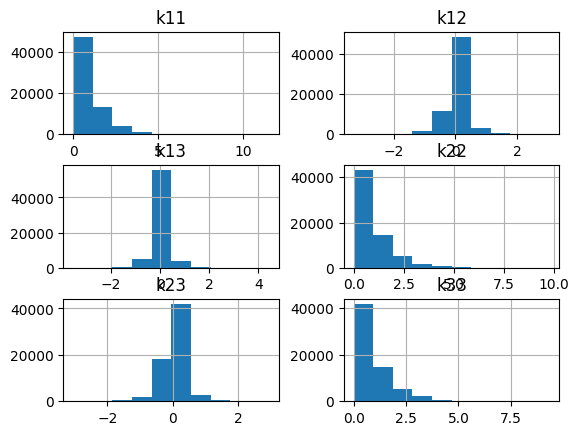

In [15]:
df[outputs].hist()

(array([  105.,   397.,   981.,  2212.,  4913., 10068., 16935., 20895.,
         8637.,   393.]),
 array([-6.85411973, -5.92423855, -4.99435736, -4.06447618, -3.13459499,
        -2.20471381, -1.27483263, -0.34495144,  0.58492974,  1.51481093,
         2.44469211]),
 <BarContainer object of 10 artists>)

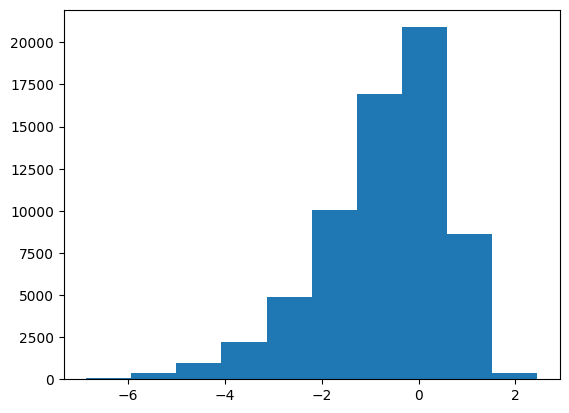

In [17]:
plt.hist(np.log(df['k11'].values))